<a href="https://colab.research.google.com/github/wareissoft/2024_VAI/blob/main/%EC%8B%9C%EA%B0%81%EC%A7%80%EB%8A%A5_10%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10을 CNN으로 학습하기, 여러 학습 방법으로 비교**

In [133]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

# (8) learning rate decay
from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 10

In [134]:
# 데이터 증강 추가
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# **1. CIFAR10 train, test dataset 가져오기 (163MB)**

In [135]:
cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform=transform, target_transform=None, download=True)
cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


# **2. 대략적인 데이터 형태**

cifar_train 길이 :  50000
cifar_test 길이 :  10000
image.data 형태 :  torch.Size([3, 32, 32])
label :  9


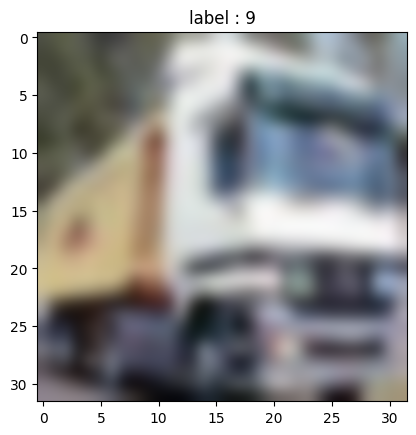

In [136]:
print ("cifar_train 길이 : ", len(cifar_train))
print ("cifar_test 길이 : ", len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 첫번째 데이터
print ("image.data 형태 : ", image.size())
print ("label : ", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (3, 32, 32)
img2 = np.transpose(img, (1, 2, 0)) # (3, 32, 32) -> (32, 32, 3)

plt.title("label : %d" %label)
plt.imshow(img2, interpolation = "bicubic")
plt.show()

In [137]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader):  # batch_size 만큼
        imgs = Variable(imgs, volatile=True) # x
        label = Variable(labels)

        output = imodel.forward(imgs)  # forward prop
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print("Accuraccy of Test Data : {}".format(100 * correct / total))

# **3. 모델 선언 및 학습**

In [138]:
# 데이터 로드 함수
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# 모델 선언
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(256, 100),
            nn.LeakyReLU(0.1),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)  # 배치 크기와 상관없이 펼치기
        out = self.fc_layer(out)

        return out

model = CNN()

In [139]:
# loss, optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model.train()
# 학습
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader):
        x = Variable(imgs)
        y_ = Variable(labels)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(j, loss)

0 tensor(2.2800, grad_fn=<NllLossBackward0>)
1000 tensor(1.6723, grad_fn=<NllLossBackward0>)
2000 tensor(1.3201, grad_fn=<NllLossBackward0>)
3000 tensor(0.9388, grad_fn=<NllLossBackward0>)
0 tensor(1.5574, grad_fn=<NllLossBackward0>)
1000 tensor(0.7764, grad_fn=<NllLossBackward0>)
2000 tensor(0.8196, grad_fn=<NllLossBackward0>)
3000 tensor(1.2903, grad_fn=<NllLossBackward0>)
0 tensor(1.0822, grad_fn=<NllLossBackward0>)
1000 tensor(1.7535, grad_fn=<NllLossBackward0>)
2000 tensor(0.6569, grad_fn=<NllLossBackward0>)
3000 tensor(0.8988, grad_fn=<NllLossBackward0>)
0 tensor(1.1508, grad_fn=<NllLossBackward0>)
1000 tensor(1.0531, grad_fn=<NllLossBackward0>)
2000 tensor(0.9530, grad_fn=<NllLossBackward0>)
3000 tensor(1.3185, grad_fn=<NllLossBackward0>)
0 tensor(1.0006, grad_fn=<NllLossBackward0>)
1000 tensor(1.2152, grad_fn=<NllLossBackward0>)
2000 tensor(0.6974, grad_fn=<NllLossBackward0>)
3000 tensor(0.7114, grad_fn=<NllLossBackward0>)
0 tensor(0.7351, grad_fn=<NllLossBackward0>)
1000 tenso

# **4. 파라미터 저장 & 로드**

In [142]:
#학습된 파라미터 저장
netname = '/content/drive/MyDrive/model/my/my_net01.pkl'
torch.save(model, netname, )

In [143]:
#저장된 파라미터 로드
netname = '/content/drive/MyDrive/model/my/my_net01.pkl'
model = torch.load(netname)

#성능 확인
ComputeAccr(test_loader, model)

<ipython-input-137-6559322b1c85>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 71.52999877929688


# **(0) Before**

In [16]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-13-1542116e6dd2>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 25.350000381469727


# **(1) LeakyReLU**

In [20]:
model.eval()
ComputeAccr(test_loader, model)

Accuraccy of Test Data : 15.289999961853027


# **(2) ELU**

In [23]:
model.eval()
ComputeAccr(test_loader, model)

Accuraccy of Test Data : 26.290000915527344


# **(3) SELU**

In [26]:
model.eval()
ComputeAccr(test_loader, model)

Accuraccy of Test Data : 41.61000061035156


# **(4) fully-connected layer**

In [30]:
model.eval()
ComputeAccr(test_loader, model)

Accuraccy of Test Data : 32.9900016784668


# **(5) epoch**

In [55]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-52-1542116e6dd2>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 54.06999969482422


# **(6) learning rate**

In [70]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data : 18.780000686645508


# **(7) data augmentation**

In [96]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-93-1542116e6dd2>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 33.0099983215332


# **(8) SELU + data augmentation**

In [100]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-97-db994c829f59>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuracy of Test Data : 45.970001220703125


# **(9) SELU + data augmentation + fully-connected layer**

In [108]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-105-f617ef296c09>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True)  # x


Accuracy of Test Data : 39.90999984741211


# **(10) LeakyReLU + fully-connected layer + learning rate + data augmentation**

In [116]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-113-6559322b1c85>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 60.20000076293945


# **(10) ELU + fully-connected layer + learning rate + data augmentation**

In [124]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-121-6559322b1c85>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 59.54999923706055


# **(10) SELU + fully-connected layer + learning rate + data augmentation**

In [132]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-129-6559322b1c85>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 52.02000045776367


# **(11) LeakyLU + fully-connected layer + learning rate + data augmentation + epoch 10**

In [140]:
model.eval()
ComputeAccr(test_loader, model)

<ipython-input-137-6559322b1c85>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  imgs = Variable(imgs, volatile=True) # x


Accuraccy of Test Data : 71.52999877929688
